<a href="https://colab.research.google.com/github/nimra7a/Computer-Vision-Projects/blob/main/alzheimer's_detection_using_Autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Upload your kaggle.json credentials file
from google.colab import files
files.upload()

# Setup Kaggle credentials
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset
!kaggle datasets download -d borhanitrash/alzheimer-mri-disease-classification-dataset

# Unzip the dataset
!unzip alzheimer-mri-disease-classification-dataset.zip -d alzheimer_mri_data


Saving kaggle.json to kaggle (1).json
Dataset URL: https://www.kaggle.com/datasets/borhanitrash/alzheimer-mri-disease-classification-dataset
License(s): apache-2.0
alzheimer-mri-disease-classification-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  alzheimer-mri-disease-classification-dataset.zip
replace alzheimer_mri_data/Alzheimer MRI Disease Classification Dataset/Data/test-00000-of-00001-44110b9df98c5585.parquet? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: alzheimer_mri_data/Alzheimer MRI Disease Classification Dataset/Data/test-00000-of-00001-44110b9df98c5585.parquet  
replace alzheimer_mri_data/Alzheimer MRI Disease Classification Dataset/Data/train-00000-of-00001-c08a401c53fe5312.parquet? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: alzheimer_mri_data/Alzheimer MRI Disease Classification Dataset/Data/train-00000-of-00001-c08a401c53fe5312.parquet  
replace alzheimer_mri_data/Alzheimer MRI Disease Classifica

In [ ]:
!pip install nibabel scikit-image --quiet
!pip install pandas pyarrow --quiet


In [ ]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import matplotlib.pyplot as plt
import random
from sklearn.metrics import roc_auc_score


In [ ]:
# List all files inside the extracted directory
import os

data_dir = "/content/alzheimer_mri_data"
for root, dirs, files in os.walk(data_dir):
    for file in files:
        print(os.path.join(root, file))


/content/alzheimer_mri_data/Alzheimer MRI Disease Classification Dataset/README.md
/content/alzheimer_mri_data/Alzheimer MRI Disease Classification Dataset/Data/train-00000-of-00001-c08a401c53fe5312.parquet
/content/alzheimer_mri_data/Alzheimer MRI Disease Classification Dataset/Data/test-00000-of-00001-44110b9df98c5585.parquet


In [ ]:
# Inspect a sample image field
#sample = df['image'].iloc[0]
#print("Type:", type(sample))
#print("Raw content preview:", str(sample)[:300])  # Print first 300 chars

import pandas as pd

train_path = '/content/alzheimer_mri_data/Alzheimer MRI Disease Classification Dataset/Data/train-00000-of-00001-c08a401c53fe5312.parquet'
df = pd.read_parquet(train_path)

# Check the columns and data
print(df.columns)
print(df.head())


Index(['image', 'label'], dtype='object')
                                               image  label
0  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...      2
1  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...      0
2  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...      3
3  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...      3
4  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...      2


In [ ]:
from PIL import Image
import io

def decode_image_bytes(img_dict):
    img_bytes = img_dict['bytes']
    img = Image.open(io.BytesIO(img_bytes)).convert('L')  # grayscale
    img = img.resize((64, 64))  # resize for consistency
    return np.array(img, dtype=np.float32)

# Decode all images
decoded_images = np.stack([decode_image_bytes(img) for img in df['image']])

# Normalize to [-1, 1]
decoded_images = (decoded_images - decoded_images.min()) / (decoded_images.max() - decoded_images.min())
decoded_images = (decoded_images * 2) - 1

# Reshape to match PyTorch expectations: (N, 1, 64, 64)
mri_images = decoded_images[:, np.newaxis, :, :]

print("Final Shape:", mri_images.shape)  # e.g., (5000, 1, 64, 64)


Final Shape: (5120, 1, 64, 64)


In [ ]:
import torch.nn as nn

class Encoder2D(nn.Module):
    def __init__(self, latent_dim=1000):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 4, 2, 1), nn.BatchNorm2d(32), nn.LeakyReLU(0.2),
            nn.Conv2d(32, 64, 4, 2, 1), nn.BatchNorm2d(64), nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, 4, 2, 1), nn.BatchNorm2d(256), nn.LeakyReLU(0.2),
        )
        self.fc = nn.Linear(256 * 4 * 4, latent_dim)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

class Generator2D(nn.Module):
    def __init__(self, latent_dim=1000):
        super().__init__()
        self.fc = nn.Linear(latent_dim, 256 * 4 * 4)
        self.deconv = nn.Sequential(
            nn.BatchNorm2d(256), nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 4, 2, 1), nn.Tanh()
        )

    def forward(self, z):
        x = self.fc(z).view(-1, 256, 4, 4)
        return self.deconv(x)

class Discriminator2D(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(1, 32, 4, 2, 1), nn.LeakyReLU(0.2),
            nn.Conv2d(32, 64, 4, 2, 1), nn.BatchNorm2d(64), nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, 4, 2, 1), nn.BatchNorm2d(256), nn.LeakyReLU(0.2),
        )
        self.fc = nn.Linear(256 * 4 * 4, 1)

    def forward(self, x):
        x = self.main(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

class CodeDiscriminator(nn.Module):
    def __init__(self, latent_dim=1000):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 512), nn.LeakyReLU(0.2), nn.BatchNorm1d(512),
            nn.Linear(512, 256), nn.LeakyReLU(0.2), nn.BatchNorm1d(256),
            nn.Linear(256, 1)
        )

    def forward(self, z):
        return self.model(z)


In [ ]:
def compute_gradient_penalty(D, real_samples, fake_samples, device='cuda'):
    """Wasserstein GP loss"""
    alpha = torch.rand(real_samples.size(0), 1, 1, 1).to(device)
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = D(interpolates)
    fake = torch.ones_like(d_interpolates, requires_grad=False).to(device)

    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gp = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gp


In [ ]:
# Hyperparameters
latent_dim = 512
lr = 2e-4
lambda_gp = 20
lambda_recon = 100
batch_size = 32
epochs = 80
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize models
E = Encoder2D(latent_dim).to(device)
G = Generator2D(latent_dim).to(device)
D = Discriminator2D().to(device)
C = CodeDiscriminator(latent_dim).to(device)

# Optimizers
optimizer_EG = torch.optim.Adam(list(E.parameters()) + list(G.parameters()), lr=lr, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_C = torch.optim.Adam(C.parameters(), lr=lr, betas=(0.5, 0.999))

# DataLoader
from torch.utils.data import DataLoader, TensorDataset
tensor_dataset = TensorDataset(torch.tensor(mri_images))
loader = DataLoader(tensor_dataset, batch_size=batch_size, shuffle=True)


In [ ]:
import torch.nn.functional as F


In [ ]:
import torch.nn.functional as F
from tqdm import tqdm

# === Utility for image gradient penalty ===
def compute_gradient_penalty(D, real_samples, fake_samples, device='cuda'):
    alpha = torch.rand(real_samples.size(0), 1, 1, 1).to(device)
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = D(interpolates)
    fake = torch.ones_like(d_interpolates, requires_grad=False).to(device)

    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gp = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gp

# === Utility for latent vector gradient penalty ===
def compute_gradient_penalty_latent(C, real_z, fake_z, device='cuda'):
    alpha = torch.rand(real_z.size(0), 1).to(device)
    interpolates = (alpha * real_z + (1 - alpha) * fake_z).requires_grad_(True)
    d_interpolates = C(interpolates)
    fake = torch.ones_like(d_interpolates, requires_grad=False).to(device)

    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gp = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gp

# === Training Loop ===
for epoch in range(epochs):
    EG_loss_total, D_loss_total, C_loss_total = 0, 0, 0
    for i, (real_imgs,) in enumerate(tqdm(loader)):
        real_imgs = real_imgs.to(device)

        # ------------------ Train Encoder + Generator ------------------ #
        optimizer_EG.zero_grad()

        z_e = E(real_imgs)
        x_rec = G(z_e)

        z_r = torch.randn(real_imgs.size(0), latent_dim).to(device)
        x_gen = G(z_r)

        g_loss = -D(x_rec).mean() - D(x_gen).mean()
        recon_loss = F.l1_loss(x_rec, real_imgs)
        EG_loss = g_loss + lambda_recon * recon_loss

        EG_loss.backward()
        optimizer_EG.step()

        # ------------------ Train Discriminator ------------------ #
        optimizer_D.zero_grad()

        d_real = D(real_imgs)
        d_fake_rec = D(x_rec.detach())
        d_fake_gen = D(x_gen.detach())
        gp_d = compute_gradient_penalty(D, real_imgs.data, x_gen.data)

        D_loss = -d_real.mean() + 0.5 * (d_fake_rec.mean() + d_fake_gen.mean()) + lambda_gp * gp_d
        D_loss.backward()
        optimizer_D.step()

        # ------------------ Train Code Discriminator ------------------ #
        optimizer_C.zero_grad()

        cd_real = C(z_r)
        cd_fake = C(z_e.detach())
        gp_c = compute_gradient_penalty_latent(C, z_r, z_e.detach())

        C_loss = -cd_real.mean() + cd_fake.mean() + lambda_gp * gp_c
        C_loss.backward()
        optimizer_C.step()

        # Track losses
        EG_loss_total += EG_loss.item()
        D_loss_total += D_loss.item()
        C_loss_total += C_loss.item()

    print(f"[Epoch {epoch+1}/{epochs}] EG Loss: {EG_loss_total:.2f}, D Loss: {D_loss_total:.2f}, C Loss: {C_loss_total:.2f}")


100%|██████████| 160/160 [00:08<00:00, 18.02it/s]


[Epoch 1/80] EG Loss: 10094.18, D Loss: -8060.46, C Loss: 3200.00


100%|██████████| 160/160 [00:06<00:00, 23.61it/s]


[Epoch 2/80] EG Loss: 11087.02, D Loss: -1235.95, C Loss: 3200.00


100%|██████████| 160/160 [00:06<00:00, 22.88it/s]


[Epoch 3/80] EG Loss: 10025.91, D Loss: -117.44, C Loss: 3200.00


100%|██████████| 160/160 [00:07<00:00, 21.24it/s]


[Epoch 4/80] EG Loss: 10007.66, D Loss: 18.48, C Loss: 3200.00


100%|██████████| 160/160 [00:07<00:00, 20.88it/s]


[Epoch 5/80] EG Loss: 9896.20, D Loss: 15.47, C Loss: 3200.00


100%|██████████| 160/160 [00:07<00:00, 22.39it/s]


[Epoch 6/80] EG Loss: 9844.14, D Loss: -4.20, C Loss: 3200.00


100%|██████████| 160/160 [00:07<00:00, 22.73it/s]


[Epoch 7/80] EG Loss: 9728.05, D Loss: -17.42, C Loss: 3200.00


100%|██████████| 160/160 [00:07<00:00, 22.34it/s]


[Epoch 8/80] EG Loss: 9577.84, D Loss: -17.91, C Loss: 3200.00


100%|██████████| 160/160 [00:06<00:00, 23.00it/s]


[Epoch 9/80] EG Loss: 9442.10, D Loss: -36.92, C Loss: 3200.00


100%|██████████| 160/160 [00:07<00:00, 22.68it/s]


[Epoch 10/80] EG Loss: 9311.85, D Loss: -41.00, C Loss: 3200.00


100%|██████████| 160/160 [00:07<00:00, 20.77it/s]


[Epoch 11/80] EG Loss: 9210.21, D Loss: -41.82, C Loss: 3200.00


100%|██████████| 160/160 [00:08<00:00, 19.51it/s]


[Epoch 12/80] EG Loss: 9147.07, D Loss: -44.19, C Loss: 3200.00


100%|██████████| 160/160 [00:07<00:00, 22.75it/s]


[Epoch 13/80] EG Loss: 9070.19, D Loss: -49.57, C Loss: 3200.00


100%|██████████| 160/160 [00:06<00:00, 23.20it/s]


[Epoch 14/80] EG Loss: 9000.51, D Loss: -52.32, C Loss: 3200.00


100%|██████████| 160/160 [00:06<00:00, 22.95it/s]


[Epoch 15/80] EG Loss: 8969.71, D Loss: -53.40, C Loss: 3200.00


100%|██████████| 160/160 [00:07<00:00, 22.68it/s]


[Epoch 16/80] EG Loss: 8887.24, D Loss: -53.55, C Loss: 3200.00


100%|██████████| 160/160 [00:06<00:00, 23.20it/s]


[Epoch 17/80] EG Loss: 8788.67, D Loss: -51.33, C Loss: 3200.00


100%|██████████| 160/160 [00:07<00:00, 22.45it/s]


[Epoch 18/80] EG Loss: 9175.24, D Loss: 31.06, C Loss: 3200.00


100%|██████████| 160/160 [00:06<00:00, 23.03it/s]


[Epoch 19/80] EG Loss: 8815.16, D Loss: -48.22, C Loss: 3200.00


100%|██████████| 160/160 [00:08<00:00, 19.18it/s]


[Epoch 20/80] EG Loss: 8672.51, D Loss: -45.26, C Loss: 3200.00


100%|██████████| 160/160 [00:07<00:00, 22.52it/s]


[Epoch 21/80] EG Loss: 8576.12, D Loss: -40.71, C Loss: 3200.00


100%|██████████| 160/160 [00:06<00:00, 22.98it/s]


[Epoch 22/80] EG Loss: 8458.10, D Loss: -39.92, C Loss: 3200.00


100%|██████████| 160/160 [00:07<00:00, 22.34it/s]


[Epoch 23/80] EG Loss: 8348.22, D Loss: -38.46, C Loss: 3200.00


100%|██████████| 160/160 [00:06<00:00, 23.04it/s]


[Epoch 24/80] EG Loss: 8321.85, D Loss: -40.23, C Loss: 3200.00


100%|██████████| 160/160 [00:07<00:00, 22.43it/s]


[Epoch 25/80] EG Loss: 8223.69, D Loss: -38.88, C Loss: 3200.00


100%|██████████| 160/160 [00:07<00:00, 22.37it/s]


[Epoch 26/80] EG Loss: 8152.82, D Loss: -36.71, C Loss: 3200.00


100%|██████████| 160/160 [00:06<00:00, 22.94it/s]


[Epoch 27/80] EG Loss: 8127.70, D Loss: -38.09, C Loss: 3200.00


100%|██████████| 160/160 [00:07<00:00, 22.43it/s]


[Epoch 28/80] EG Loss: 8060.46, D Loss: -37.66, C Loss: 3200.00


100%|██████████| 160/160 [00:06<00:00, 23.10it/s]


[Epoch 29/80] EG Loss: 8009.89, D Loss: -38.47, C Loss: 3200.00


100%|██████████| 160/160 [00:07<00:00, 22.40it/s]


[Epoch 30/80] EG Loss: 7973.70, D Loss: -39.28, C Loss: 3200.00


100%|██████████| 160/160 [00:06<00:00, 23.00it/s]


[Epoch 31/80] EG Loss: 7941.19, D Loss: -39.54, C Loss: 3200.00


100%|██████████| 160/160 [00:07<00:00, 22.78it/s]


[Epoch 32/80] EG Loss: 7881.25, D Loss: -41.84, C Loss: 3200.00


100%|██████████| 160/160 [00:07<00:00, 22.52it/s]


[Epoch 33/80] EG Loss: 7891.41, D Loss: -40.08, C Loss: 3200.00


100%|██████████| 160/160 [00:06<00:00, 23.13it/s]


[Epoch 34/80] EG Loss: 7840.86, D Loss: -44.24, C Loss: 3200.00


100%|██████████| 160/160 [00:07<00:00, 22.63it/s]


[Epoch 35/80] EG Loss: 7780.52, D Loss: -42.81, C Loss: 3200.00


100%|██████████| 160/160 [00:06<00:00, 23.13it/s]


[Epoch 36/80] EG Loss: 7814.19, D Loss: -48.25, C Loss: 3200.00


100%|██████████| 160/160 [00:07<00:00, 22.59it/s]


[Epoch 37/80] EG Loss: 7694.29, D Loss: -47.87, C Loss: 3200.00


100%|██████████| 160/160 [00:07<00:00, 22.65it/s]


[Epoch 38/80] EG Loss: 7695.02, D Loss: -49.09, C Loss: 3200.00


100%|██████████| 160/160 [00:06<00:00, 22.92it/s]


[Epoch 39/80] EG Loss: 7640.79, D Loss: -48.64, C Loss: 3200.00


100%|██████████| 160/160 [00:07<00:00, 22.55it/s]


[Epoch 40/80] EG Loss: 7624.83, D Loss: -51.34, C Loss: 3200.00


100%|██████████| 160/160 [00:06<00:00, 23.02it/s]


[Epoch 41/80] EG Loss: 7585.54, D Loss: -52.72, C Loss: 3200.00


100%|██████████| 160/160 [00:07<00:00, 22.54it/s]


[Epoch 42/80] EG Loss: 7552.78, D Loss: -55.17, C Loss: 3200.00


100%|██████████| 160/160 [00:06<00:00, 22.96it/s]


[Epoch 43/80] EG Loss: 7544.45, D Loss: -60.51, C Loss: 3200.00


100%|██████████| 160/160 [00:07<00:00, 22.69it/s]


[Epoch 44/80] EG Loss: 7552.94, D Loss: -61.90, C Loss: 3200.00


100%|██████████| 160/160 [00:07<00:00, 22.41it/s]


[Epoch 45/80] EG Loss: 7456.52, D Loss: -64.58, C Loss: 3200.00


100%|██████████| 160/160 [00:06<00:00, 23.14it/s]


[Epoch 46/80] EG Loss: 7473.04, D Loss: -63.86, C Loss: 3200.00


100%|██████████| 160/160 [00:07<00:00, 21.21it/s]


[Epoch 47/80] EG Loss: 7430.55, D Loss: -67.50, C Loss: 3200.00


100%|██████████| 160/160 [00:06<00:00, 23.20it/s]


[Epoch 48/80] EG Loss: 7431.65, D Loss: -72.78, C Loss: 3200.00


100%|██████████| 160/160 [00:07<00:00, 22.68it/s]


[Epoch 49/80] EG Loss: 7424.50, D Loss: -76.22, C Loss: 3200.00


100%|██████████| 160/160 [00:06<00:00, 22.97it/s]


[Epoch 50/80] EG Loss: 7400.85, D Loss: -77.94, C Loss: 3200.00


100%|██████████| 160/160 [00:07<00:00, 22.64it/s]


[Epoch 51/80] EG Loss: 7407.76, D Loss: -78.81, C Loss: 3200.00


100%|██████████| 160/160 [00:07<00:00, 22.69it/s]


[Epoch 52/80] EG Loss: 7366.01, D Loss: -81.64, C Loss: 3200.00


100%|██████████| 160/160 [00:06<00:00, 23.24it/s]


[Epoch 53/80] EG Loss: 7277.18, D Loss: -83.78, C Loss: 3200.00


100%|██████████| 160/160 [00:07<00:00, 22.69it/s]


[Epoch 54/80] EG Loss: 7286.11, D Loss: -92.17, C Loss: 3200.00


100%|██████████| 160/160 [00:06<00:00, 23.27it/s]


[Epoch 55/80] EG Loss: 7295.28, D Loss: -87.27, C Loss: 3200.00


100%|██████████| 160/160 [00:07<00:00, 22.66it/s]


[Epoch 56/80] EG Loss: 7391.64, D Loss: -103.34, C Loss: 3200.00


100%|██████████| 160/160 [00:06<00:00, 22.94it/s]


[Epoch 57/80] EG Loss: 7283.35, D Loss: -92.49, C Loss: 3200.00


100%|██████████| 160/160 [00:06<00:00, 22.99it/s]


[Epoch 58/80] EG Loss: 7220.62, D Loss: -96.85, C Loss: 3200.00


100%|██████████| 160/160 [00:07<00:00, 22.62it/s]


[Epoch 59/80] EG Loss: 7226.07, D Loss: -96.96, C Loss: 3200.00


100%|██████████| 160/160 [00:06<00:00, 23.20it/s]


[Epoch 60/80] EG Loss: 7131.86, D Loss: -105.57, C Loss: 3200.00


100%|██████████| 160/160 [00:07<00:00, 22.68it/s]


[Epoch 61/80] EG Loss: 7154.40, D Loss: -100.57, C Loss: 3200.00


100%|██████████| 160/160 [00:06<00:00, 23.13it/s]


[Epoch 62/80] EG Loss: 7060.72, D Loss: -115.28, C Loss: 3200.00


100%|██████████| 160/160 [00:07<00:00, 22.60it/s]


[Epoch 63/80] EG Loss: 7044.25, D Loss: -108.73, C Loss: 3200.00


100%|██████████| 160/160 [00:07<00:00, 22.55it/s]


[Epoch 64/80] EG Loss: 6960.16, D Loss: -117.22, C Loss: 3200.00


100%|██████████| 160/160 [00:06<00:00, 23.21it/s]


[Epoch 65/80] EG Loss: 6957.09, D Loss: -113.25, C Loss: 3200.00


100%|██████████| 160/160 [00:07<00:00, 22.62it/s]


[Epoch 66/80] EG Loss: 6932.74, D Loss: -101.36, C Loss: 3200.00


100%|██████████| 160/160 [00:06<00:00, 23.24it/s]


[Epoch 67/80] EG Loss: 6827.31, D Loss: -124.51, C Loss: 3200.00


100%|██████████| 160/160 [00:07<00:00, 22.58it/s]


[Epoch 68/80] EG Loss: 6809.05, D Loss: -91.40, C Loss: 3200.00


100%|██████████| 160/160 [00:06<00:00, 22.95it/s]


[Epoch 69/80] EG Loss: 6764.50, D Loss: -112.43, C Loss: 3200.00


100%|██████████| 160/160 [00:06<00:00, 22.90it/s]


[Epoch 70/80] EG Loss: 6634.61, D Loss: -143.84, C Loss: 3199.99


100%|██████████| 160/160 [00:07<00:00, 22.51it/s]


[Epoch 71/80] EG Loss: 6541.02, D Loss: -143.33, C Loss: 3199.99


100%|██████████| 160/160 [00:06<00:00, 23.07it/s]


[Epoch 72/80] EG Loss: 6514.24, D Loss: -135.66, C Loss: 3200.00


100%|██████████| 160/160 [00:07<00:00, 22.44it/s]


[Epoch 73/80] EG Loss: 6404.95, D Loss: -143.65, C Loss: 3199.99


100%|██████████| 160/160 [00:07<00:00, 22.46it/s]


[Epoch 74/80] EG Loss: 6348.78, D Loss: -140.83, C Loss: 3199.99


100%|██████████| 160/160 [00:07<00:00, 22.46it/s]


[Epoch 75/80] EG Loss: 6285.74, D Loss: -153.80, C Loss: 3199.99


100%|██████████| 160/160 [00:07<00:00, 22.47it/s]


[Epoch 76/80] EG Loss: 6186.12, D Loss: -95.51, C Loss: 3199.99


100%|██████████| 160/160 [00:06<00:00, 23.09it/s]


[Epoch 77/80] EG Loss: 5984.04, D Loss: -150.19, C Loss: 3199.99


100%|██████████| 160/160 [00:07<00:00, 22.60it/s]


[Epoch 78/80] EG Loss: 5900.65, D Loss: -159.12, C Loss: 3199.99


100%|██████████| 160/160 [00:06<00:00, 23.18it/s]


[Epoch 79/80] EG Loss: 5829.24, D Loss: -165.07, C Loss: 3199.99


100%|██████████| 160/160 [00:07<00:00, 22.58it/s]

[Epoch 80/80] EG Loss: 5837.16, D Loss: -148.02, C Loss: 3199.99


In [ ]:
# Wrap the preprocessed MRI array into a PyTorch Dataset
from torch.utils.data import Dataset

class MRIDataset(Dataset):
    def __init__(self, images):
        self.data = images

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx], dtype=torch.float32)

# Re-instantiate the dataset (make sure mri_images is already defined)
dataset = MRIDataset(mri_images)


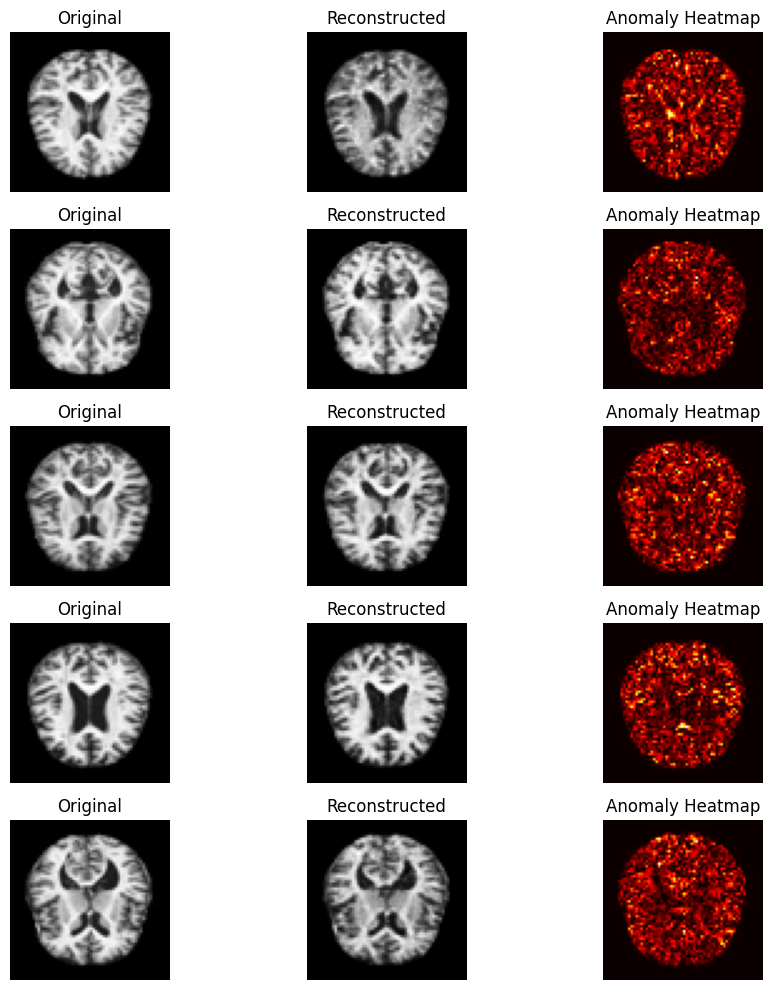

In [ ]:
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as compare_ssim
from skimage.metrics import peak_signal_noise_ratio as compare_psnr

def visualize_reconstruction(model_E, model_G, dataset, n=5):
    model_E.eval()
    model_G.eval()

    fig, axes = plt.subplots(n, 3, figsize=(10, 2 * n))
    with torch.no_grad():
        for i in range(n):
            img = dataset[i]
            input_img = img.unsqueeze(0).to(device)
            latent = model_E(input_img)
            recon = model_G(latent).cpu().squeeze(0).squeeze(0)

            original = img.squeeze(0)

            # Heatmap (residual)
            residual = torch.abs(original - recon)

            # Plot
            axes[i, 0].imshow(original.numpy(), cmap='gray')
            axes[i, 0].set_title("Original")
            axes[i, 1].imshow(recon.numpy(), cmap='gray')
            axes[i, 1].set_title("Reconstructed")
            axes[i, 2].imshow(residual.numpy(), cmap='hot')
            axes[i, 2].set_title("Anomaly Heatmap")

            for j in range(3):
                axes[i, j].axis('off')
    plt.tight_layout()
    plt.show()

# Call visualization
visualize_reconstruction(E, G, dataset)


In [ ]:
from sklearn.metrics import roc_auc_score

def evaluate_quality(model_E, model_G, dataset, true_labels=None):
    ssim_scores = []
    psnr_scores = []
    residual_scores = []

    model_E.eval()
    model_G.eval()

    with torch.no_grad():
        for i in range(len(dataset)):
            img = dataset[i].unsqueeze(0).to(device)
            latent = model_E(img)
            recon = model_G(latent).cpu().squeeze().numpy()
            original = dataset[i].squeeze().numpy()

            # Compute metrics
            ssim_val = compare_ssim(original, recon, data_range=2.0)
            psnr_val = compare_psnr(original, recon, data_range=2.0)
            residual = np.mean(np.abs(original - recon))

            ssim_scores.append(ssim_val)
            psnr_scores.append(psnr_val)
            residual_scores.append(residual)

    print(f"\nAverage SSIM: {np.mean(ssim_scores):.4f}")
    print(f"Average PSNR: {np.mean(psnr_scores):.2f} dB")

    # AUC evaluation (only if binary labels are available: 0=normal, 1=anomaly)
    if true_labels is not None:
        auc_score = roc_auc_score(true_labels[:len(residual_scores)], residual_scores)
        print(f"AUC Score (Residual): {auc_score:.4f}")

# Optional: if you have true_labels from df['label'], pass them here.
# Example: evaluate_quality(E, G, dataset, true_labels=df['label'].values)
evaluate_quality(E, G, dataset)



Average SSIM: 0.8906
Average PSNR: 24.68 dB


In [ ]:
!pip install pytorch_msssim


In [ ]:
from skimage.metrics import structural_similarity as ssim
import numpy as np

def evaluate_ssim_mmd(model_E, model_G, dataset):
    model_E.eval()
    model_G.eval()

    real_imgs = []
    recon_imgs = []
    latents_real = []
    latents_fake = []

    with torch.no_grad():
        for i in range(len(dataset)):
            img = dataset[i].unsqueeze(0).to(device)  # (1, 1, 64, 64)
            latent = model_E(img)
            recon = model_G(latent)

            real = img.cpu().squeeze().numpy()
            recon_np = recon.cpu().squeeze().numpy()
            ssim_val = ssim(real, recon_np, data_range=2.0)

            real_imgs.append(ssim_val)
            latents_real.append(latent.cpu())
            latents_fake.append(model_E(recon.to(device)).cpu())

    print(f"Average SSIM: {np.mean(real_imgs):.4f}")

    latents_real = torch.cat(latents_real)
    latents_fake = torch.cat(latents_fake)

    def compute_mmd(x, y, sigma=1.0):
        def gaussian_kernel(a, b):
            a = a.unsqueeze(1)
            b = b.unsqueeze(0)
            return torch.exp(-((a - b) ** 2).sum(2) / (2 * sigma ** 2))

        xx = gaussian_kernel(x, x)
        yy = gaussian_kernel(y, y)
        xy = gaussian_kernel(x, y)
        return xx.mean() + yy.mean() - 2 * xy.mean()

    mmd_val = compute_mmd(latents_real, latents_fake)
    print(f"MMD Score: {mmd_val.item():.4f}")

# Run it
evaluate_ssim_mmd(E, G, dataset)


Average SSIM: 0.8906
